In [1]:
from imports import *

# Fetch dataset

In [2]:
target_anomaly_rate = 0.2

df = pd.read_csv('kddcup.data', delimiter=',')
df.columns = sa_columns + ["target"]
df_normal = df[df["target"]== 'normal.']
n_records = int(np.ceil(len(df_normal)*target_anomaly_rate))

df = df_normal.append(df[df["target"]!= 'normal.'].sample(n = n_records, random_state=1))
anomaly_rate = 1.0 - len(df.loc[df["target"]=='normal.'])/len(df)
print(f"anomaly rate is {anomaly_rate:.1%} out of {len(df)} records ({n_records})")

df['binary_target'] = [1 if x=='normal.' else -1 for x in df["target"]]
df = df.sample(frac=1, random_state=2)
toDecode = ["protocol_type", "service", "flag", "target"]
leSF = preprocessing.LabelEncoder()
for f in toDecode:
    df[f] = leSF.fit_transform(df[f])

x_train, x_test, y_train, y_test = train_test_split(df.drop(["target", 'binary_target'], axis=1), df['binary_target'], test_size=0.33, random_state=0)
results = []

anomaly rate is 16.7% out of 1167336 records (194556)


Just like with sklearn SA dataset, we selected all of the 'normal' data with a small portion of outliers to reach our target anomaly rate

# Cross-validation for Isolation Forest

In [3]:
def cross_validation(contamination):
    highest_score = 0
    highest_score_c = 0
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c).fit(x_train).predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        fp = len(prediction) - tp
        
        print(f"contamination: {c} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [4]:
print(set(np.array(y_test)))

{1, -1}


In [5]:
contamination = [0.01]
c_max = cross_validation(contamination)
c_max

1197
contamination: 0.01 	 tp: 1197/63899 -> fp = 62702
AUC : 50.5% 	 precision: 0.311 	 recall: 0.0187 	 f1: 0.035337879727216366
--------------------


0.01

In [6]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation(contamination)
c_max

1197
contamination: 0.01 	 tp: 1197/63899 -> fp = 62702
AUC : 50.5% 	 precision: 0.311 	 recall: 0.0187 	 f1: 0.035337879727216366
--------------------
2582
contamination: 0.02 	 tp: 2582/63899 -> fp = 61317
AUC : 51.2% 	 precision: 0.329 	 recall: 0.0404 	 f1: 0.07198316118150518
--------------------
4307
contamination: 0.03 	 tp: 4307/63899 -> fp = 59592
AUC : 52.2% 	 precision: 0.371 	 recall: 0.0674 	 f1: 0.11410027154116166
--------------------
5013
contamination: 0.04 	 tp: 5013/63899 -> fp = 58886
AUC : 52.3% 	 precision: 0.327 	 recall: 0.0785 	 f1: 0.1265158302522493
--------------------
5483
contamination: 0.05 	 tp: 5483/63899 -> fp = 58416
AUC : 52.2% 	 precision: 0.285 	 recall: 0.0858 	 f1: 0.13191704359541911
--------------------
6101
contamination: 0.06 	 tp: 6101/63899 -> fp = 57798
AUC : 52.1% 	 precision: 0.263 	 recall: 0.0955 	 f1: 0.14007415825785494
--------------------
6917
contamination: 0.07 	 tp: 6917/63899 -> fp = 56982
AUC : 52.3% 	 precision: 0.256 	 recal

0.1

In [7]:
contamination = [round(0.1*i, 1) for i in range(1, 7)]
c_max_2 = cross_validation(contamination)
c_max_2

10981
contamination: 0.1 	 tp: 10981/63899 -> fp = 52918
AUC : 54.2% 	 precision: 0.282 	 recall: 0.172 	 f1: 0.21366307351052652
--------------------
21788
contamination: 0.2 	 tp: 21788/63899 -> fp = 42111
AUC : 58.4% 	 precision: 0.281 	 recall: 0.341 	 f1: 0.30810130520242657
--------------------
28127
contamination: 0.3 	 tp: 28127/63899 -> fp = 35772
AUC : 58.8% 	 precision: 0.248 	 recall: 0.44 	 f1: 0.3174300433931282
--------------------
32479
contamination: 0.4 	 tp: 32479/63899 -> fp = 31420
AUC : 58.3% 	 precision: 0.228 	 recall: 0.508 	 f1: 0.314679352407158
--------------------
63899
contamination: 0.5 	 tp: 63899/63899 -> fp = 0
AUC : 80.0% 	 precision: 0.333 	 recall: 1.0 	 f1: 0.4991660905465524
--------------------
63899
contamination: 0.6 	 tp: 63899/63899 -> fp = 0
AUC : 74.0% 	 precision: 0.276 	 recall: 1.0 	 f1: 0.43311665864586224
--------------------


0.5

In [8]:
c_max = c_max_2 if c_max_2 > c_max else c_max

In [9]:
contamination = [round(c_max - 0.1 + 0.01*i, 2) for i in range(11)]
c_max = cross_validation(contamination)
c_max

32479
contamination: 0.4 	 tp: 32479/63899 -> fp = 31420
AUC : 58.3% 	 precision: 0.228 	 recall: 0.508 	 f1: 0.314679352407158
--------------------
32479
contamination: 0.41 	 tp: 32479/63899 -> fp = 31420
AUC : 58.3% 	 precision: 0.228 	 recall: 0.508 	 f1: 0.314679352407158
--------------------
32479
contamination: 0.42 	 tp: 32479/63899 -> fp = 31420
AUC : 58.3% 	 precision: 0.228 	 recall: 0.508 	 f1: 0.314679352407158
--------------------
32479
contamination: 0.43 	 tp: 32479/63899 -> fp = 31420
AUC : 58.3% 	 precision: 0.228 	 recall: 0.508 	 f1: 0.314679352407158
--------------------
32479
contamination: 0.44 	 tp: 32479/63899 -> fp = 31420
AUC : 58.3% 	 precision: 0.228 	 recall: 0.508 	 f1: 0.314679352407158
--------------------
32479
contamination: 0.45 	 tp: 32479/63899 -> fp = 31420
AUC : 58.3% 	 precision: 0.228 	 recall: 0.508 	 f1: 0.314679352407158
--------------------
63899
contamination: 0.47 	 tp: 63899/63899 -> fp = 0
AUC : 81.8% 	 precision: 0.353 	 recall: 1.0 	 

0.46

AUC: 82.4%
              precision    recall  f1-score   support

          -1       0.36      1.00      0.53     63899
           1       1.00      0.65      0.79    321322

    accuracy                           0.71    385221
   macro avg       0.68      0.82      0.66    385221
weighted avg       0.89      0.71      0.74    385221



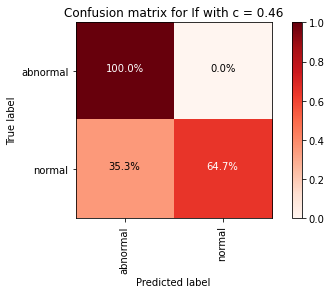

In [10]:
y_pred = IsolationForest(random_state=1, n_jobs=-1, max_samples=0.25, n_estimators=100, contamination=c_max).fit(x_train).predict(x_test)
cm_if = confusion_matrix(y_test, y_pred)
print(f"AUC: {roc_auc_score(y_test, y_pred):.1%}")
print(classification_report(y_test, y_pred))
plot_confusion_matrix(cm_if, f"Confusion matrix for If with c = {c_max}")

## Cross validation for LOF 

In [5]:
def cross_validation_lof(contamination):
    highest_score = 0
    highest_score_c = 0
    #print("array:", contamination)
    for c in contamination:
        s = datetime.datetime.now()
        y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c, n_jobs=-1).fit_predict(x_test)
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; highest_score_c = c
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"{len(positives)} ({tp}) -> fp = {len(positives) - tp}/{fp}")
        
        print(f"contamination: {c} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return highest_score_c

In [12]:
contamination = [round(0.1 + 0.1*i, 2) for i in range(5)]
c_max = cross_validation_lof(contamination)
c_max

38522 (3552) -> fp = 34970/34970.0
contamination: 0.1 	 tp: 3552/63899 -> fp = 34970.0
AUC : 47.3% 	 precision: 0.0922 	 recall: 0.0556 	 f1: 0.06936077562218686
--------------------
77044 (6656) -> fp = 70388/70388.0
contamination: 0.2 	 tp: 6656/63899 -> fp = 70388.0
AUC : 44.3% 	 precision: 0.0864 	 recall: 0.104 	 f1: 0.09444952924231781
--------------------
115566 (8726) -> fp = 106840/106840.0
contamination: 0.3 	 tp: 8726/63899 -> fp = 106840.0
AUC : 40.2% 	 precision: 0.0755 	 recall: 0.137 	 f1: 0.09724458808124146
--------------------
154088 (10259) -> fp = 143829/143829.0
contamination: 0.4 	 tp: 10259/63899 -> fp = 143829.0
AUC : 35.6% 	 precision: 0.0666 	 recall: 0.161 	 f1: 0.09412487900654626
--------------------
192610 (12168) -> fp = 180442/180442.0
contamination: 0.5 	 tp: 12168/63899 -> fp = 180442.0
AUC : 31.4% 	 precision: 0.0632 	 recall: 0.19 	 f1: 0.09487386407494475
--------------------


0.2

In [13]:
contamination = [round(0.01 + 0.01*i, 2) for i in range(10)]
c_max = cross_validation_lof(contamination)
c_max

3850 (1041) -> fp = 2809/2809.0
contamination: 0.01 	 tp: 1041/63899 -> fp = 2809.0
AUC : 50.4% 	 precision: 0.27 	 recall: 0.0163 	 f1: 0.03073108090156312
--------------------
7704 (1196) -> fp = 6508/6508.0
contamination: 0.02 	 tp: 1196/63899 -> fp = 6508.0
AUC : 49.9% 	 precision: 0.155 	 recall: 0.0187 	 f1: 0.033406421518651454
--------------------
11557 (1705) -> fp = 9852/9852.0
contamination: 0.03 	 tp: 1705/63899 -> fp = 9852.0
AUC : 49.8% 	 precision: 0.148 	 recall: 0.0267 	 f1: 0.04519189991518236
--------------------
15409 (2066) -> fp = 13343/13343.0
contamination: 0.04 	 tp: 2066/63899 -> fp = 13343.0
AUC : 49.5% 	 precision: 0.134 	 recall: 0.0323 	 f1: 0.052100670802441115
--------------------
19261 (2343) -> fp = 16918/16918.0
contamination: 0.05 	 tp: 2343/63899 -> fp = 16918.0
AUC : 49.2% 	 precision: 0.122 	 recall: 0.0367 	 f1: 0.056349206349206336
--------------------
23114 (2571) -> fp = 20543/20543.0
contamination: 0.06 	 tp: 2571/63899 -> fp = 20543.0
AUC : 

0.01

In [6]:
c_max = 0.2

In [7]:
contamination = [round(c_max-0.01 + 0.001*i, 3) for i in range(1,10)]
c_max = cross_validation_lof(contamination)
c_max

73578 (6442) -> fp = 67136/67136.0
contamination: 0.191 	 tp: 6442/63899 -> fp = 67136.0
AUC : 44.6% 	 precision: 0.0876 	 recall: 0.101 	 f1: 0.09371749456272685
--------------------
73963 (6458) -> fp = 67505/67505.0
contamination: 0.192 	 tp: 6458/63899 -> fp = 67505.0
AUC : 44.5% 	 precision: 0.0873 	 recall: 0.101 	 f1: 0.09368789078934006
--------------------
74348 (6492) -> fp = 67856/67856.0
contamination: 0.193 	 tp: 6492/63899 -> fp = 67856.0
AUC : 44.5% 	 precision: 0.0873 	 recall: 0.102 	 f1: 0.0939188553820336
--------------------
74733 (6523) -> fp = 68210/68210.0
contamination: 0.194 	 tp: 6523/63899 -> fp = 68210.0
AUC : 44.5% 	 precision: 0.0873 	 recall: 0.102 	 f1: 0.09410525708350163
--------------------
75118 (6550) -> fp = 68568/68568.0
contamination: 0.195 	 tp: 6550/63899 -> fp = 68568.0
AUC : 44.5% 	 precision: 0.0872 	 recall: 0.103 	 f1: 0.09423307940755447
--------------------
75504 (6576) -> fp = 68928/68928.0
contamination: 0.196 	 tp: 6576/63899 -> fp = 

0.191

trainning LOF in 0:02:45.077594
              precision    recall  f1-score   support

     anomaly       0.06      0.19      0.09     63899
      normal       0.73      0.44      0.55    321322

    accuracy                           0.40    385221
   macro avg       0.40      0.31      0.32    385221
weighted avg       0.62      0.40      0.47    385221

AUC:  31.4%


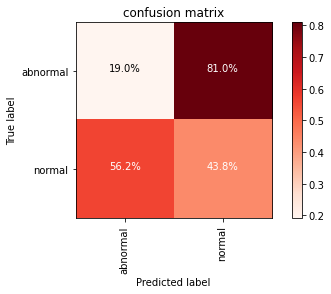

In [8]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=0.5, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

trainning LOF in 0:02:44.324680
              precision    recall  f1-score   support

     anomaly       0.09      0.10      0.09     63899
      normal       0.82      0.79      0.80    321322

    accuracy                           0.68    385221
   macro avg       0.45      0.45      0.45    385221
weighted avg       0.69      0.68      0.69    385221

AUC:  44.6%


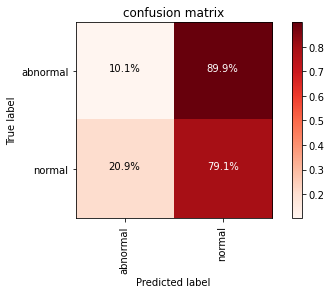

In [9]:
start = datetime.datetime.now()
y_pred = LocalOutlierFactor(n_neighbors=100, metric='euclidean', algorithm = 'auto', contamination=c_max, n_jobs=-1).fit_predict(x_test)
trainning_time = datetime.datetime.now() - start
print(f"trainning LOF in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))

# DBSCAN

Tested parameters: 
* eps

In [10]:
def cross_validation_dbscan(eps):
    highest_score = 0
    best_eps = 0
    for e in eps:
        s = datetime.datetime.now()
        db = DBSCAN(eps=e, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
        y_pred = [1 if i != -1 else i for i in db.labels_]
        t = datetime.datetime.now() - s
        p, r, f, s = map(lambda x: x[0], precision_recall_fscore_support(y_test, y_pred, labels=[-1]))
        # p = tp / (tp + fp)
        a = roc_auc_score(y_test, y_pred)
        if p + r + a > highest_score: highest_score = p + r + a; best_eps = e
        
        yp = np.array(y_pred)
        yt = np.array(y_test)
        
        prediction = yp[np.where(yt == -1)]

        tp = len(yp[np.where(prediction == -1)])
        print(tp)
        # fp through formula
        fp = tp / p - tp
        
        # predicted true
        positives = yp[np.where(yp == -1)]
        print(f"{len(positives)} ({tp}) -> fp = {len(positives) - tp}/{fp}")
        print(f"eps: {e} \t tp: {tp}/{s} -> fp = {fp}")
        print(f"AUC : {a:.1%} \t precision: {p:.3} \t recall: {r:.3} \t f1: {f}")
        print("--------------------")
    return best_eps

In [ ]:
eps = [round(0.1 + 0.1*i, 2) for i in range(5)]
e_max = cross_validation_dbscan(eps)
e_max

In [ ]:
eps = [round(0.01 + 0.01*i, 2) for i in range(10)]
e_max = cross_validation_dbscan(eps)
e_max

In [ ]:
e_max = 0.08

In [ ]:
eps = [round(e_max-0.01 + 0.001*i, 3) for i in range(1,10)]
e_max = cross_validation_lof(contamination)
e_max

In [ ]:
start = datetime.datetime.now()
db = DBSCAN(eps=e_max, min_samples=10, metric='euclidean', algorithm = 'auto', n_jobs=-1).fit(x_test)
y_pred = [1 if i != -1 else i for i in db.labels_]
trainning_time = datetime.datetime.now() - start
print(f"trainning Isolation Forest in {trainning_time}")
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "confusion matrix")
print(classification_report(y_test, y_pred, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test, y_pred)))